In [8]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import warnings
from tqdm import tqdm
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import pickle 
device = "cuda" if torch.cuda.is_available() else "cpu" 

In [9]:
def Load_preprocessed_data():
    #### Data downloaded  from: https://bioconductor.org/packages/devel/data/experiment/vignettes/TENxPBMCData/inst/doc/TENxPBMCData.html
    adata = sc.read_10x_mtx(
                            'data/filtered_matrices_mex/hg19/',  # the directory with the `.mtx` file
                            var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
                            cache=True)                              # write a cache file for faster subsequent reading
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.n_genes_by_counts < 2000, :]
    adata = adata[adata.obs.pct_counts_mt < 5, :]
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=1838)
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
    sc.pp.scale(adata, max_value=10)
    df = pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var.index)

    # Scale each variable between 0 and 1 where zero is the minimum value of all observations and one the max
    max_vals = np.max(df, axis=0)
    min_vals = np.min(df, axis=0)
    scaled_df = (df - np.min(min_vals)) / (np.max(max_vals) - np.min(min_vals))
    adata.X = scaled_df.to_numpy()
    adata.X = np.float32(adata.X)

    sc.tl.pca(adata, svd_solver='arpack')

    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(adata,resolution=0.6, key_added="leiden_pca")
    sc.tl.umap(adata)
    
    return adata

In [10]:
adata = Load_preprocessed_data()
print(adata)

/home/muellert/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 68250 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_pca'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [11]:
### model based on: https://sannaperzon.medium.com/paper-summary-variational-autoencoders-with-pytorch-implementation-1b4b23b1763a
### and https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

def ModelsNN(dim_encoder_decoder=2048,dim_hidden=1024,dim_latent=40):
    class AE(nn.Module):
        def __init__(self, dim_encoder_decoder, dim_hidden, dim_latent):
            super(AE , self).__init__()
            self.encoder = nn.Sequential(                       # sequential operation of the following code:
                nn.Linear(dim_encoder_decoder, dim_hidden),           # decoding laten layer (784 -> 256 nodes)
                nn.ReLU(),   
                nn.Linear(dim_hidden, dim_latent),
            )

            self.decoder = nn.Sequential(                             # sequential operation of the following code:
                nn.Linear(dim_latent, dim_hidden),                    # decoding laten layer (16 -> 256 nodes)
                nn.ReLU(),                                            # activation function f(x) = max(0, x)
                nn.Linear(dim_hidden, dim_encoder_decoder),           # reconstruction of image (256 -> 784)
                nn.Sigmoid()                                     # rescale values between ]0,1[ by the sigmoidal function
            )

        def forward(self, x):                                         # 
            latent = self.encoder(x)
            decoded = self.decoder(latent)
            return latent, decoded                           # return the decoded vector, mean, standard devation, latent vector


    model_AE = AE(dim_encoder_decoder, dim_hidden, dim_latent).to(device)
    
    class VAE(nn.Module):
        def __init__(self, dim_encoder_decoder, dim_hidden, dim_latent):
            super(VAE , self).__init__()
            
            self.encoder_layer = nn.Sequential(                       # sequential operation of the following code:
                nn.Linear(dim_encoder_decoder, dim_hidden),           # decoding laten layer (784 -> 256 nodes)
                nn.ReLU(),                                            # activation function
            )
            
            self.hidden_to_mu = nn.Linear(dim_hidden, dim_latent)     # hidden layer in dim_latent for mu
            self.hidden_to_sigma = nn.Linear(dim_hidden, dim_latent)  # hidden layer in dim_latent for sigma

            self.decoder = nn.Sequential(                             # sequential operation of the following code:
                nn.Linear(dim_latent, dim_hidden),                    # decoding laten layer (16 -> 256 nodes)
                nn.ReLU(),                                            # activation function f(x) = max(0, x)
                nn.Linear(dim_hidden, dim_encoder_decoder),           # reconstruction of image (256 -> 784)
                nn.Sigmoid() #nn.Softmax()                            # rescale values between ]0,1[ by the sigmoidal function
            )

        def encoder(self, x):
            hidden_layer = self.encoder_layer(x)                      #
            mu = self.hidden_to_mu(hidden_layer)                      # get the mean
            sigma = self.hidden_to_sigma(hidden_layer)                # get the standard devation
            return mu , sigma                                         # return the encoded 


        def forward(self, x):                                         # 
            mu, sigma = self.encoder(x)                               # compute the variance and mean of a reduced dim
            epsilon = torch.randn_like(sigma)                         # random noice ### "Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1"
            z = mu + sigma*epsilon                                    # reparametrization # compute latent layer from reduced dim of mu and sigma and some random noice
            decoded = self.decoder(z)                                 # decode latent layer
            return decoded , mu, sigma , z                            # return the decoded vector, mean, standard devation, latent vector

    model_VAE = VAE(dim_encoder_decoder, dim_hidden, dim_latent).to(device)

    return model_AE, model_VAE

In [12]:
def Model_Training(model="AE",learning_rate=5e-5,epochs=[300],batch_size=24,dim=[adata.X.shape[1],1024,40],Train_data=adata.X, kl_scaling=1e-3, seed = 42):
    
    torch.manual_seed(seed)
    
    model_AE, model_VAE = ModelsNN(dim_encoder_decoder=dim[0],dim_hidden=dim[1],dim_latent=dim[2])
    
    loss_fn = nn.MSELoss( reduction='sum')
    
    adata_tensor = torch.tensor(adata.X).to(device)
    adata_tensor_loader = DataLoader(dataset=adata_tensor, batch_size=batch_size, shuffle=True)
    
    if model == "AE":

        optimizer = torch.optim.Adam(model_AE.parameters(),lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.75, patience=10,verbose=True)
        
        for n_epochs in epochs:

            loop = tqdm(np.arange(0,n_epochs))
            for epoch in loop:
                
                losses = []
                
                for batch , X in enumerate(adata_tensor_loader):
                    X = X.to(device)
                    latent , pred  = model_AE(X)
                    loss = loss_fn(pred, X)
                    
                    losses.append(loss.item())
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                loop.set_description(f"last found loss: {round(sum(losses),4)}; Total progress")
                mean_loss = sum(losses)/len(losses)
                scheduler.step(mean_loss)
        
        return model_AE
    
    elif model == "VAE":
        
        optimizer = torch.optim.Adam(model_VAE.parameters(),lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.75, patience=10,verbose=True)

        for n_epochs in epochs:
            loss_list_kl = []
            loss_list_re = []

            loop = tqdm(np.arange(0,n_epochs))
            for epoch in loop:
                
                losses = []
                losses_re = []
                losses_kl = []
                
                for batch , X in enumerate(adata_tensor_loader):
                    X = X.to(device)
                    decoded , mu, sigma , z  = model_VAE(X)
                    re_loss = loss_fn(decoded, X)
                    kl_div = - kl_scaling*torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
                    loss = re_loss + kl_div
                    
                    losses.append(loss.item())
                    losses_re.append(re_loss.item())
                    losses_kl.append(kl_div.item())
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                loss_list_re.append(sum(losses_re))
                loss_list_kl.append(sum(losses_kl))
                
                loop.set_description(f"last found loss: {round(sum(losses),1)}, RE {round(sum(losses_re),1)}, KL {round(sum(losses_kl),1)}; Total progress")
                mean_loss = sum(losses)/len(losses)
                scheduler.step(mean_loss)
                
        return model_VAE

    else:
        print(f"diffine model by the name 'AE' or 'VAE' and your input is: {model}")

In [13]:
for seed in np.arange(0,3,1):
    print(seed)
    model = Model_Training(model="AE",
                              learning_rate=5e-5,
                              epochs=[300],
                              batch_size=24,
                              dim=[adata.X.shape[1],1024,40],
                              Train_data=adata.X,
                              kl_scaling=None,
                              seed=seed
                             )
    
    FILE = f"model_AE_seed{seed}_pbmc68k.pth"
    
    torch.save(model.state_dict(),FILE)

0


last found loss: 43858.4044; Total progress: 100%|██████████| 300/300 [24:11<00:00,  4.84s/it]


1


last found loss: 43907.1642; Total progress: 100%|██████████| 300/300 [24:22<00:00,  4.87s/it]


2


last found loss: 43929.0881; Total progress: 100%|██████████| 300/300 [24:21<00:00,  4.87s/it]


In [14]:
for seed in np.arange(0,3,1):
    print(seed)
    model = Model_Training(model="VAE",
                              learning_rate=5e-5,
                              epochs=[300],
                              batch_size=24,
                              dim=[adata.X.shape[1],1024,40],
                              Train_data=adata.X,
                              kl_scaling=1e-3,
                              seed=seed
                             )
    
    FILE = f"model_VAE_seed{seed}_pbmc68k.pth"
    
    torch.save(model.state_dict(),FILE)

0


last found loss: 65600.5, RE 64678.9, KL 921.6; Total progress:  55%|█████▌    | 166/300 [16:26<13:15,  5.94s/it]

Epoch 00166: reducing learning rate of group 0 to 3.7500e-05.


last found loss: 64797.3, RE 63806.8, KL 990.5; Total progress: 100%|██████████| 300/300 [29:46<00:00,  5.96s/it] 


1


last found loss: 65579.6, RE 64684.0, KL 895.6; Total progress:  48%|████▊     | 144/300 [14:14<15:45,  6.06s/it] 

Epoch 00144: reducing learning rate of group 0 to 3.7500e-05.


last found loss: 65160.2, RE 64254.9, KL 905.2; Total progress:  73%|███████▎  | 220/300 [21:50<07:59,  6.00s/it]

Epoch 00220: reducing learning rate of group 0 to 2.8125e-05.


last found loss: 65035.6, RE 64105.8, KL 929.8; Total progress:  81%|████████  | 243/300 [24:08<05:42,  6.00s/it]

Epoch 00243: reducing learning rate of group 0 to 2.1094e-05.


last found loss: 64819.0, RE 63870.8, KL 948.2; Total progress: 100%|██████████| 300/300 [29:49<00:00,  5.96s/it]


2


last found loss: 65562.1, RE 64640.4, KL 921.7; Total progress:  45%|████▍     | 134/300 [13:12<16:32,  5.98s/it] 

Epoch 00134: reducing learning rate of group 0 to 3.7500e-05.


last found loss: 70821.0, RE 68890.9, KL 1930.1; Total progress:  83%|████████▎ | 250/300 [24:46<04:59,  6.00s/it]

Epoch 00250: reducing learning rate of group 0 to 2.8125e-05.


last found loss: 64787.0, RE 63779.5, KL 1007.6; Total progress:  92%|█████████▏| 277/300 [27:28<02:18,  6.01s/it]

Epoch 00277: reducing learning rate of group 0 to 2.1094e-05.


last found loss: 64643.4, RE 63660.6, KL 982.8; Total progress: 100%|██████████| 300/300 [29:46<00:00,  5.95s/it] 


In [16]:
adata_tensor = torch.tensor(adata.X).to(device)

For n_clusters = 76 The average silhouette_score is (AE): 0.12108383


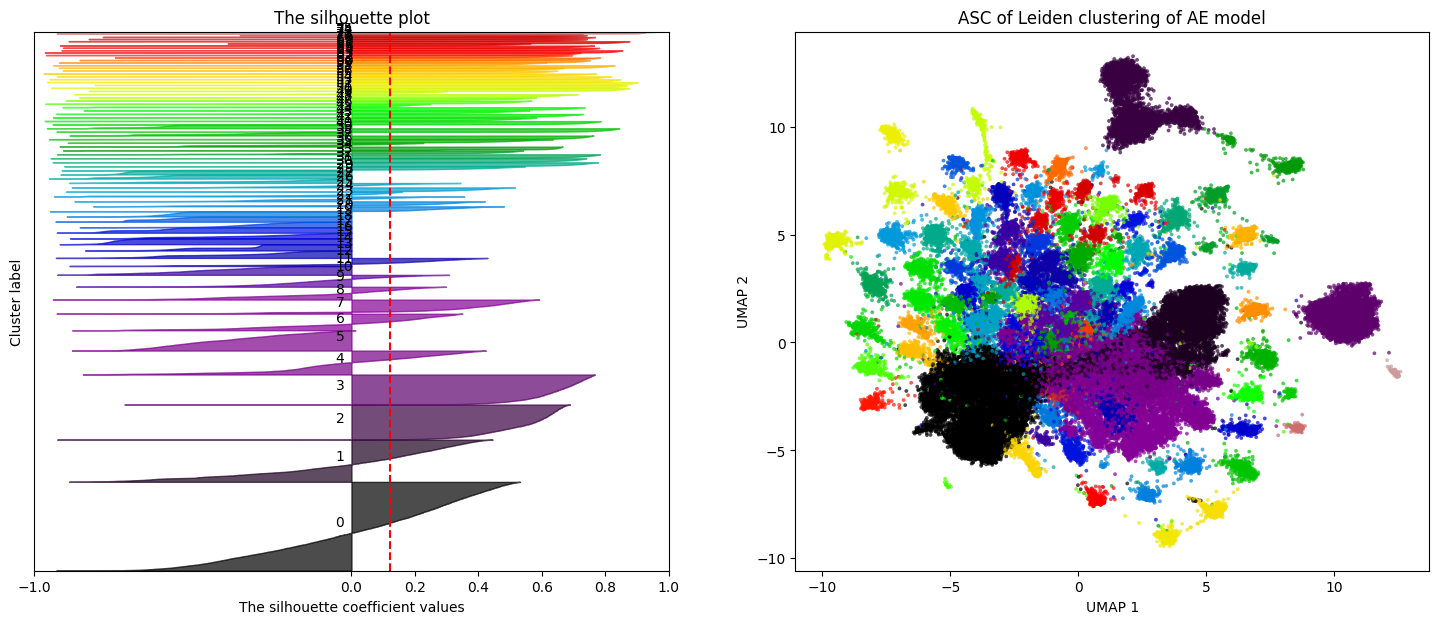

For n_clusters = 6 The average silhouette_score is (AE): -0.01694793


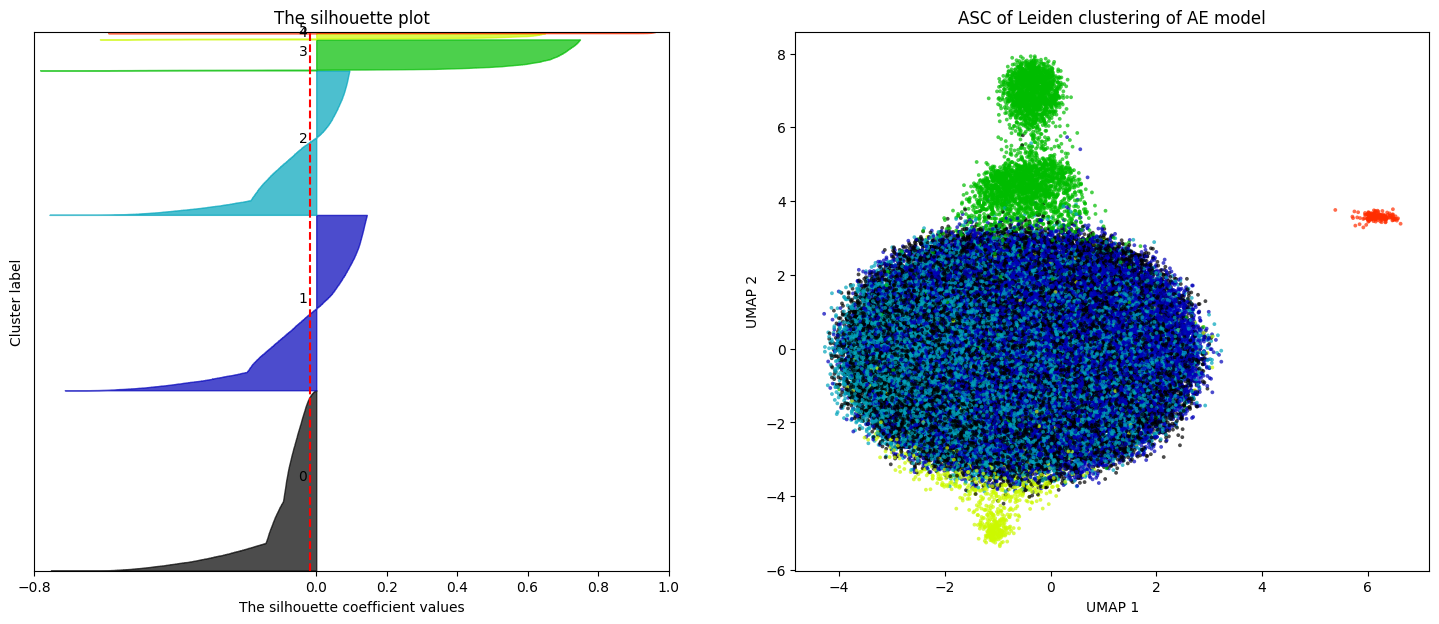

For n_clusters = 77 The average silhouette_score is (AE): 0.172494


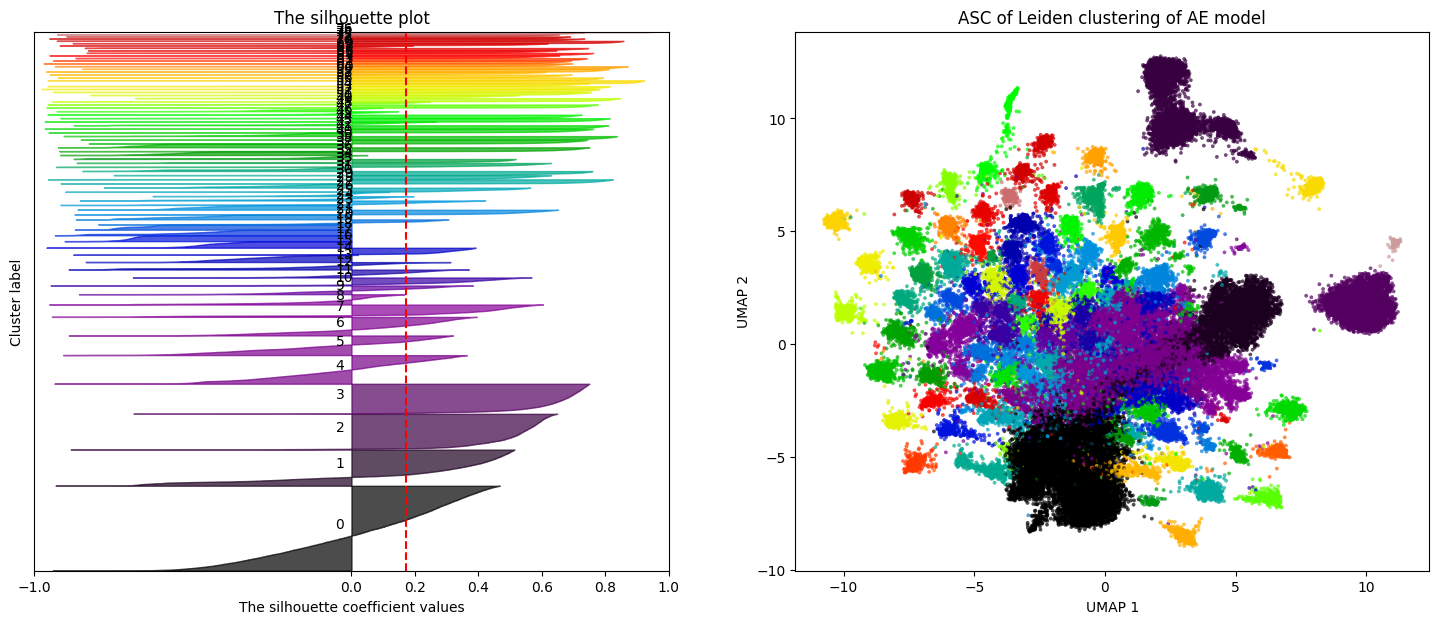

For n_clusters = 6 The average silhouette_score is (AE): 0.078143716


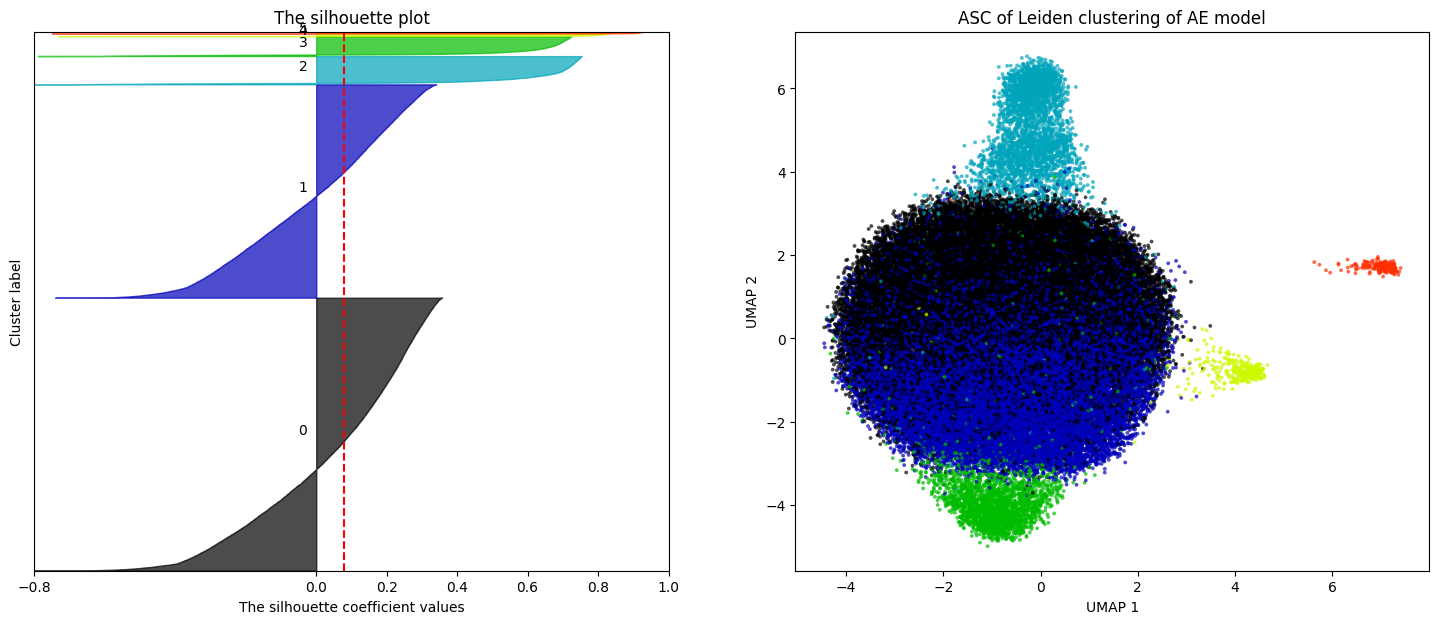

For n_clusters = 77 The average silhouette_score is (AE): 0.15064901


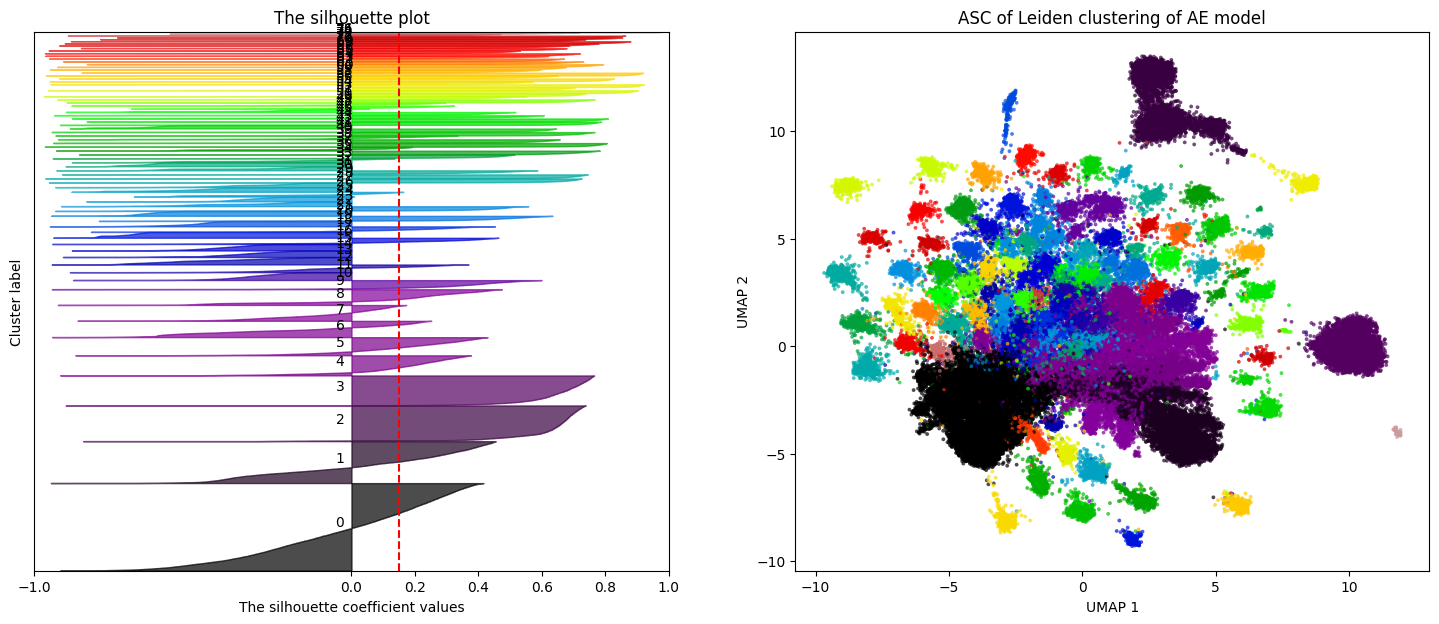

For n_clusters = 7 The average silhouette_score is (AE): -0.08702877


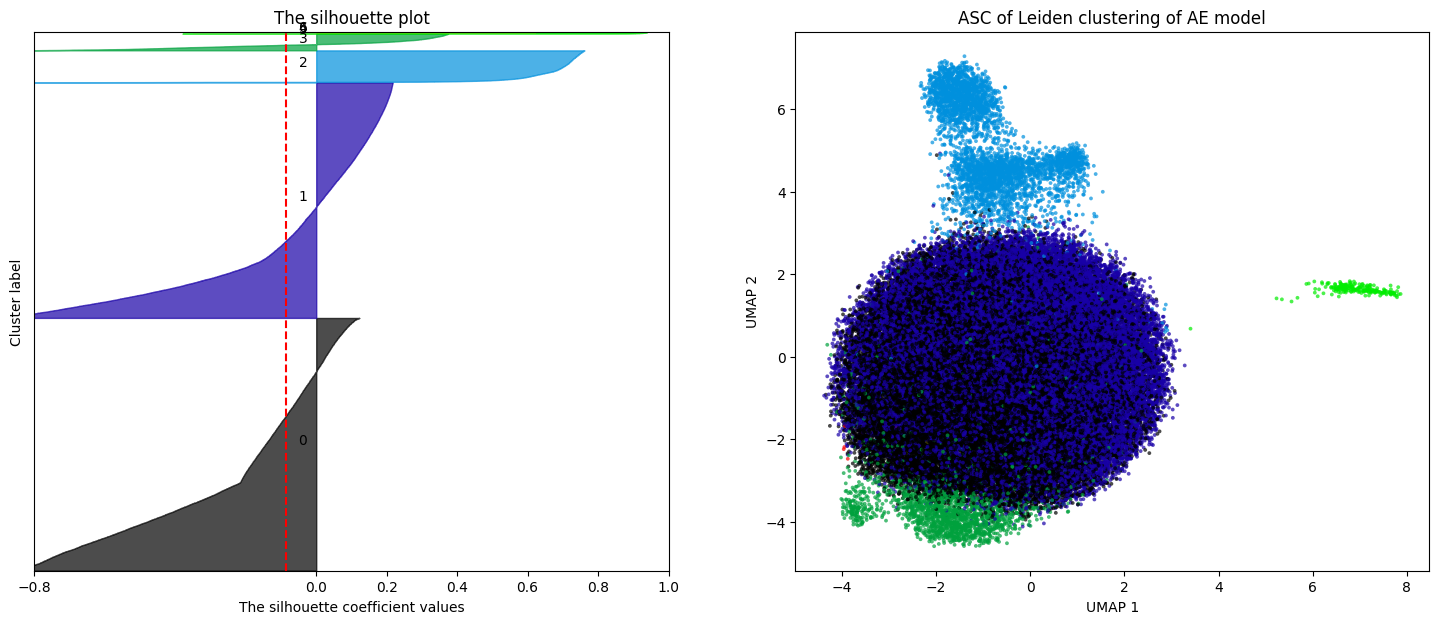

In [23]:
for seed in np.arange(0,3,1):
    
    torch.manual_seed(seed)
    
    FILE_VAE = f"model_VAE_seed{seed}_pbmc68k.pth"
    FILE_AE  = f"model_AE_seed{seed}_pbmc68k.pth"
    
    
    loaded_model_AE, loaded_model_VAE = ModelsNN(adata.X.shape[1],1024,40)
    
    loaded_model_AE.to(device)
    loaded_model_VAE.to(device)
    
    loaded_model_AE.load_state_dict(torch.load(FILE_AE, map_location=device))
    loaded_model_VAE.load_state_dict(torch.load(FILE_VAE, map_location=device))
    
    loaded_model_AE.eval()
    loaded_model_VAE.eval()
    
    adata_latent,_ = loaded_model_AE(adata_tensor)
    adata_latent_np = adata_latent.cpu().detach().numpy()
    adata.obsm["X_AE"] = adata_latent_np

    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep="X_AE")
    sc.tl.leiden(adata,resolution=0.6,)
    sc.tl.umap(adata)

    X = adata.obsm["X_umap"]
    cluster_labels = adata.obs["leiden"]
    if True: ### adapeded from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
        n_clusters=np.max([int(i)+1 for i in adata.obs["leiden"]])
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
                "For n_clusters =",
                n_clusters,
                "The average silhouette_score is (AE):",
                silhouette_avg,
            )

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[[t for t, j in enumerate(cluster_labels) if j == str(i)]]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-1, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
                X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
            )



        ax2.set_title("ASC of Leiden clustering of AE model")
        ax2.set_xlabel("UMAP 1")
        ax2.set_ylabel("UMAP 2")
        plt.show()
        
    _, _, _, adata_latent = loaded_model_VAE(adata_tensor)
    adata_latent_np = adata_latent.cpu().detach().numpy()
    adata.obsm["X_VAE"] = adata_latent_np

    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep="X_VAE")
    sc.tl.leiden(adata,resolution=0.6,)
    sc.tl.umap(adata)
        
    X = adata.obsm["X_umap"]
    cluster_labels = adata.obs["leiden"]
    if True:
        n_clusters=np.max([int(i)+1 for i in adata.obs["leiden"]])
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
                "For n_clusters =",
                n_clusters,
                "The average silhouette_score is (AE):",
                silhouette_avg,
            )

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[[t for t, j in enumerate(cluster_labels) if j == str(i)]]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.8, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
                X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
            )



        ax2.set_title("ASC of Leiden clustering of AE model")
        ax2.set_xlabel("UMAP 1")
        ax2.set_ylabel("UMAP 2")
        plt.show()

/home/muellert/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


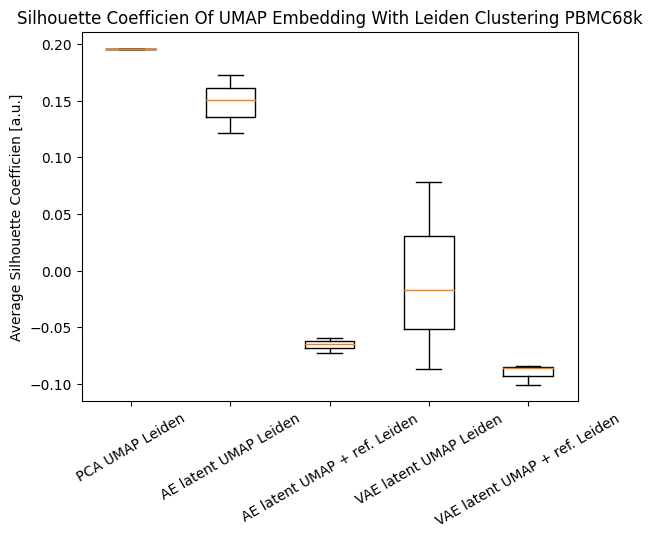

In [19]:
VAE_ASS = []
AE_ASS  = []
AE_ASS_PCA = []
VAE_ASS_PCA = []

adata = Load_preprocessed_data()
PCA_score = silhouette_score(adata.obsm["X_umap"], adata.obs["leiden_pca"])

for seed in np.arange(0,3,1):
    torch.manual_seed(seed)
    FILE_VAE = f"model_VAE_seed{seed}_pbmc68k.pth"
    FILE_AE  = f"model_AE_seed{seed}_pbmc68k.pth"
    
    loaded_model_AE, loaded_model_VAE = ModelsNN(adata.X.shape[1],1024,40)
    
    loaded_model_AE.to(device)
    loaded_model_VAE.to(device)
    
    loaded_model_AE.load_state_dict(torch.load(FILE_AE, map_location=device))
    loaded_model_VAE.load_state_dict(torch.load(FILE_VAE, map_location=device))
    
    loaded_model_AE.eval()
    loaded_model_VAE.eval()
    
    adata_latent_AE,_ = loaded_model_AE(adata_tensor)
    adata.obsm["X_AE"] = adata_latent_AE.cpu().detach().numpy()
    
    _,_,_, adata_latent_VAE = loaded_model_VAE(adata_tensor)
    adata.obsm["X_VAE"] = adata_latent_VAE.cpu().detach().numpy()

    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep="X_AE",key_added='neighbors_AE')
    sc.tl.leiden(adata,resolution=0.6,key_added="leiden_AE",neighbors_key="neighbors_AE")
    sc.tl.umap(adata, neighbors_key="neighbors_AE")
    
    AE_ASS.append(silhouette_score(adata.obsm["X_umap"], adata.obs["leiden_AE"]))
    AE_ASS_PCA.append(silhouette_score(adata.obsm["X_umap"], adata.obs["leiden_pca"]))
    
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep="X_VAE",key_added='neighbors_VAE')
    sc.tl.leiden(adata,resolution=0.6,key_added="leiden_VAE",neighbors_key="neighbors_VAE")
    sc.tl.umap(adata, neighbors_key="neighbors_VAE")

    VAE_ASS.append(silhouette_score(adata.obsm["X_umap"], adata.obs["leiden_VAE"]))
    VAE_ASS_PCA.append(silhouette_score(adata.obsm["X_umap"], adata.obs["leiden_pca"])) 

plt.boxplot([PCA_score,AE_ASS,AE_ASS_PCA,VAE_ASS,VAE_ASS_PCA])
plt.xticks([1,2,3,4,5], ['PCA UMAP Leiden', 'AE latent UMAP Leiden', 'AE latent UMAP + ref. Leiden', "VAE latent UMAP Leiden", "VAE latent UMAP + ref. Leiden"])
plt.title("Silhouette Coefficien Of UMAP Embedding With Leiden Clustering PBMC68k")
plt.xticks(rotation=30)
plt.ylabel("Average Silhouette Coefficien [a.u.]")
plt.show()

In [26]:
[PCA_score,AE_ASS,AE_ASS_PCA,VAE_ASS,VAE_ASS_PCA]

[0.19598217,
 [0.12108383, 0.172494, 0.15064901],
 [-0.05992106, -0.072601356, -0.06449414],
 [-0.01694793, 0.078143716, -0.08702877],
 [-0.1006335, -0.08607864, -0.08407254]]

In [24]:
print(np.mean(AE_ASS),np.mean(AE_ASS_PCA),np.mean(VAE_ASS),np.mean(VAE_ASS_PCA))
print(np.median(AE_ASS),np.median(AE_ASS_PCA),np.median(VAE_ASS),np.median(VAE_ASS_PCA))
print(np.mean(np.abs(np.array(AE_ASS)-np.array(AE_ASS_PCA))),np.mean(np.abs(np.array(VAE_ASS)-np.array(VAE_ASS_PCA))))
print(np.median(np.abs(np.array(AE_ASS)-np.array(AE_ASS_PCA))),np.median(np.abs(np.array(VAE_ASS)-np.array(VAE_ASS_PCA))))

0.14807561 -0.06567219 -0.008610996 -0.090261556
0.15064901 -0.06449414 -0.01694793 -0.08607864
0.2137478 0.08362139
0.21514314 0.08368557


For n_clusters = 6 The average silhouette_score is (AE): 0.078143716


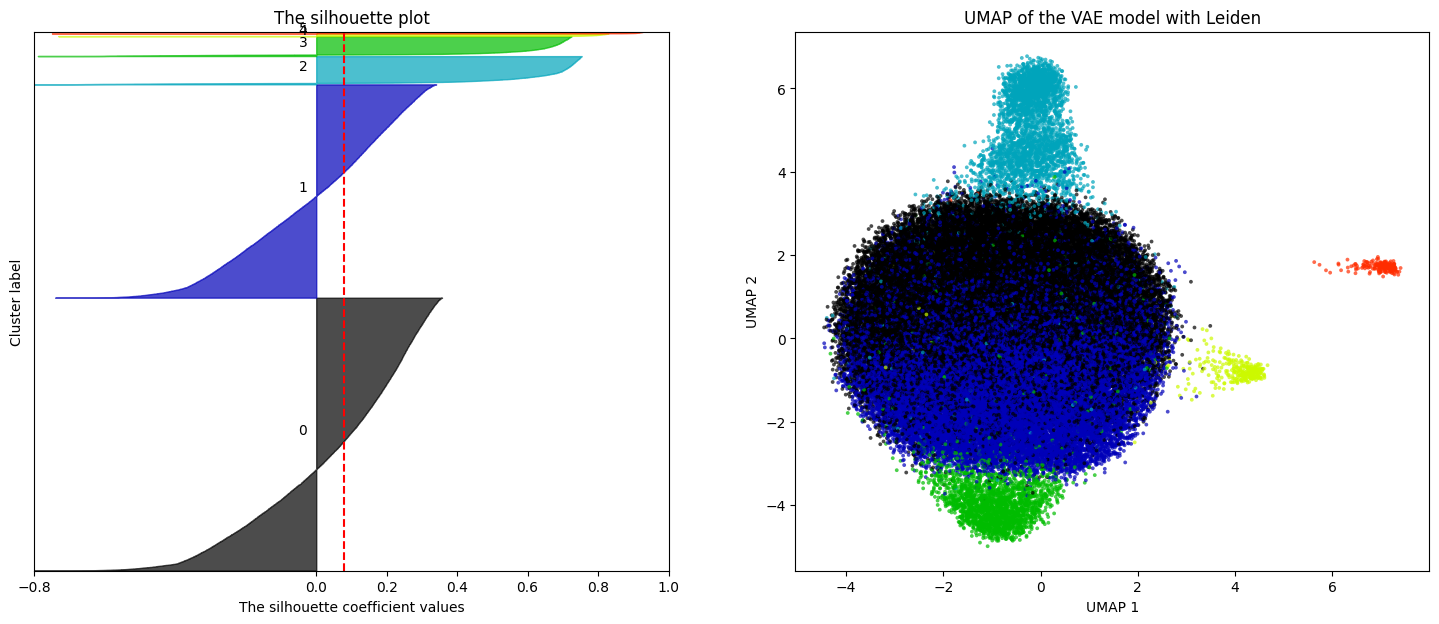

For n_clusters = 32 The average silhouette_score is (VAE): -0.08607864


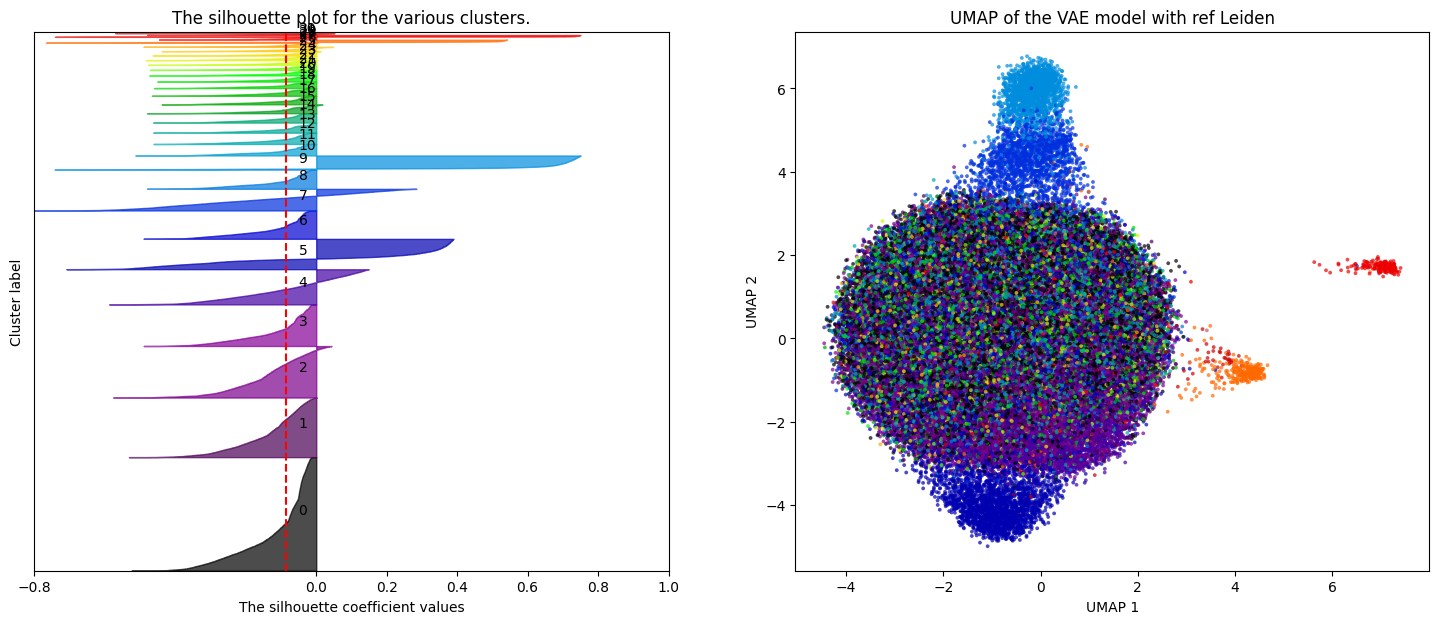

For n_clusters = 77 The average silhouette_score is (AE): 0.172494


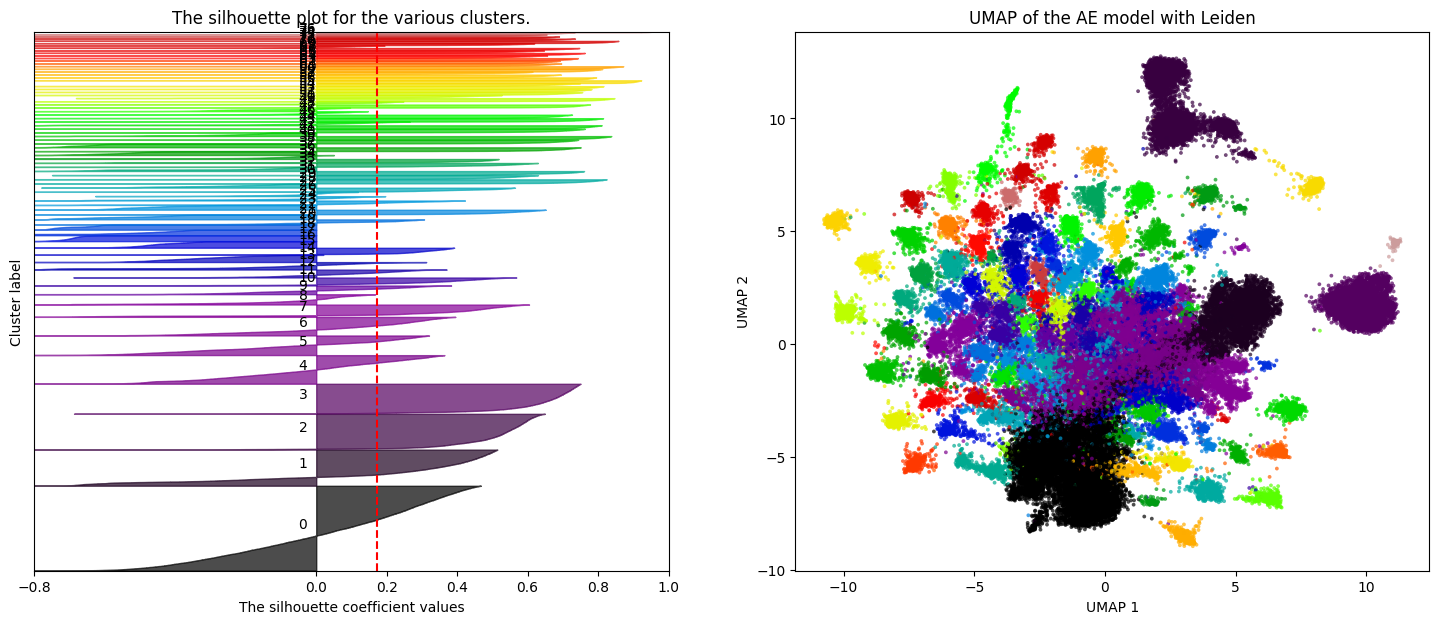

For n_clusters = 32 The average silhouette_score is (AE): -0.072601356


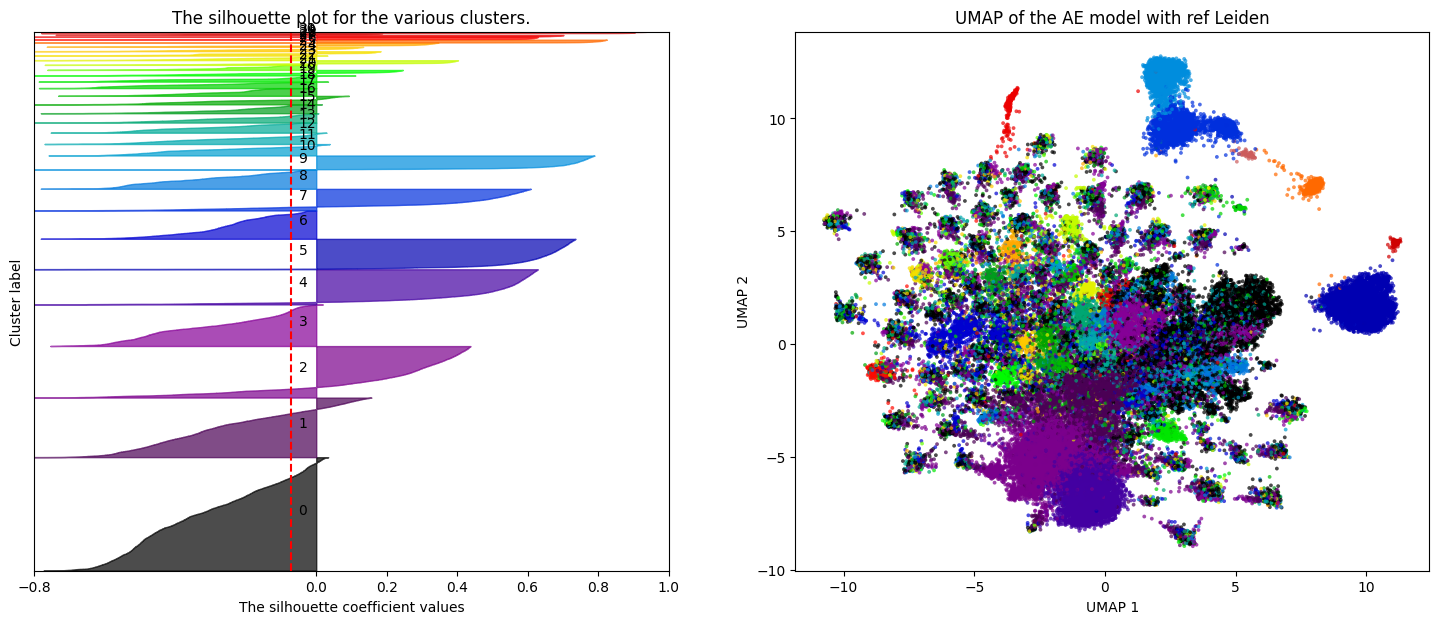

In [25]:
for seed in [1]:
    torch.manual_seed(seed)
    FILE_VAE = f"model_VAE_seed{seed}_pbmc68k.pth"
    FILE_AE  = f"model_AE_seed{seed}_pbmc68k.pth"
    
    loaded_model_AE, loaded_model_VAE = ModelsNN(adata.X.shape[1],1024,40)
    
    loaded_model_AE.to(device)
    loaded_model_VAE.to(device)
    
    loaded_model_AE.load_state_dict(torch.load(FILE_AE, map_location=device))
    loaded_model_VAE.load_state_dict(torch.load(FILE_VAE, map_location=device))
    
    loaded_model_AE.eval()
    loaded_model_VAE.eval()
    
    _,_,_,adata_latent = loaded_model_VAE(adata_tensor)
    adata_latent_np = adata_latent.cpu().detach().numpy()
    adata.obsm["X_AE"] = adata_latent_np

    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep="X_AE")
    sc.tl.leiden(adata,resolution=0.6,)
    sc.tl.umap(adata)
        
    marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                        'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                        'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

    X = adata.obsm["X_umap"]
    cluster_labels = adata.obs["leiden"]
    if True: ### adapeded from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
        n_clusters=np.max([int(i)+1 for i in adata.obs["leiden"]])
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
                "For n_clusters =",
                n_clusters,
                "The average silhouette_score is (AE):",
                silhouette_avg,
            )

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[[t for t, j in enumerate(cluster_labels) if j == str(i)]]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.8, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
                X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
            )



        ax2.set_title("UMAP of the VAE model with Leiden")
        ax2.set_xlabel("UMAP 1")
        ax2.set_ylabel("UMAP 2")

        plt.show()
    cluster_labels = adata.obs["leiden_pca"]
    if True: ### adapeded from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
        n_clusters=np.max([int(i)+1 for i in adata.obs["leiden_pca"]])
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
                "For n_clusters =",
                n_clusters,
                "The average silhouette_score is (VAE):",
                silhouette_avg,
            )

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[[t for t, j in enumerate(cluster_labels) if j == str(i)]]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.8, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
                X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
            )


        ax2.set_title("UMAP of the VAE model with ref Leiden")
        ax2.set_xlabel("UMAP 1")
        ax2.set_ylabel("UMAP 2")


        plt.show()
        
    adata_latent,_ = loaded_model_AE(adata_tensor)
    adata_latent_np = adata_latent.cpu().detach().numpy()
    adata.obsm["X_AE"] = adata_latent_np

    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep="X_AE")
    sc.tl.leiden(adata,resolution=0.6,)
    sc.tl.umap(adata)
        
    marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                        'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                        'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

    X = adata.obsm["X_umap"]
    cluster_labels = adata.obs["leiden"]
    if True: ### adapeded from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
        n_clusters=np.max([int(i)+1 for i in adata.obs["leiden"]])
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
                "For n_clusters =",
                n_clusters,
                "The average silhouette_score is (AE):",
                silhouette_avg,
            )

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[[t for t, j in enumerate(cluster_labels) if j == str(i)]]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.8, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
                X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
            )



        ax2.set_title("UMAP of the AE model with Leiden")
        ax2.set_xlabel("UMAP 1")
        ax2.set_ylabel("UMAP 2")



        plt.show()
    cluster_labels = adata.obs["leiden_pca"]
    if True: ### adapeded from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
        n_clusters=np.max([int(i)+1 for i in adata.obs["leiden_pca"]])
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
                "For n_clusters =",
                n_clusters,
                "The average silhouette_score is (AE):",
                silhouette_avg,
            )

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[[t for t, j in enumerate(cluster_labels) if j == str(i)]]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.8, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
                X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
            )



        ax2.set_title("UMAP of the AE model with ref Leiden")
        ax2.set_xlabel("UMAP 1")
        ax2.set_ylabel("UMAP 2")


        plt.show()

/home/muellert/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/muellert/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


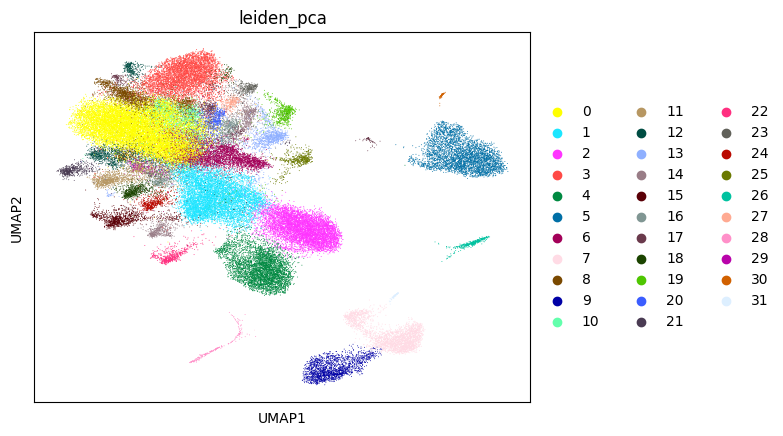

In [22]:
adata = Load_preprocessed_data()
sc.pl.umap(adata, color=["leiden_pca"])